<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sentiment-Analysis-by-States" data-toc-modified-id="Sentiment-Analysis-by-States-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sentiment Analysis by States</a></span><ul class="toc-item"><li><span><a href="#VA-Hotel-Review" data-toc-modified-id="VA-Hotel-Review-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>VA Hotel Review</a></span></li><li><span><a href="#WA-Hotel-Review" data-toc-modified-id="WA-Hotel-Review-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>WA Hotel Review</a></span></li><li><span><a href="#Compare-15-States" data-toc-modified-id="Compare-15-States-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Compare 15 States</a></span></li></ul></li></ul></div>

# Sentiment Analysis of Hotel in VA

In [1]:
import numpy as np
import pickle
from collections import Counter
import re

# nlp libraries/api
import en_core_web_lg
from spacy import displacy
import gensim
#from neuralcoref import Coref

spacy = en_core_web_lg.load()
#coref = Coref(nlp=spacy)


In [2]:
# Load opinion lexicon
neg_file = open("neg_words.txt",encoding = "ISO-8859-1")
pos_file = open("pos_words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos


In [3]:
def check_similarity(aspects, word):
    '''
    checks for word2vec similarity values between category word and the term
    returns most similar word
    '''
    similarity = []
    for aspect in aspects:
        sim = [word2vec.n_similarity([aspect], word.split())]
        for splited in word.split():
            sim.append(word2vec.n_similarity([aspect], [splited]))
        similarity.append(max(sim))
    # set threshold for max value
    if max(similarity) > 0.2:
        return aspects[np.argmax(similarity)]
    else:
        return None


def assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred):
    '''
    function: takes in a sentiment dictionary and appends the aspect dictionary
    inputs: sent_dict is a Counter in the form Counter(term:sentiment value)
            aspect_sent is total sentiment tally
            terms_dict is dict with individual aspect words associated with sentiment
    output: return two types of aspect dictionaries:
            updated terms_dict and aspect_sent
    '''
    aspects = ['location', 'checkin', 'food', 'building', 'rooms', 'cleanliness', 'value', 'service', 'business']

    # First, check word2vec
    # Note: the .split() is used for the term because word2vec can't pass compound nouns
    for term in sent_dict:
        try:
            # The conditions for when to use the NB classifier as default vs word2vec
            aspect = check_similarity(aspects, term)
            if aspect:
                terms_dict[aspect.upper()][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[aspect.upper()]["pos"] += sent_dict[term]
                else:
                    aspect_sent[aspect.upper()]["neg"] += abs(sent_dict[term])
            elif pred:
                aspect = str(pred[0]).strip("(',)")
                terms_dict[aspect.upper()][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[aspect.upper()]["pos"] += sent_dict[term]
                else:
                    aspect_sent[aspect.upper()]["neg"] += abs(sent_dict[term])
            # if unable to classify via NB or word2vec, then put them in misc. bucket
            else:
                terms_dict["OTHER"][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent["OTHER"]["pos"] += sent_dict[term]
                else:
                    aspect_sent["OTHER"]["neg"] += abs(sent_dict[term])
        except:
            #print(term, "not in vocab")
            continue
    return aspect_sent, terms_dict


def modify_sentiment(token, sentiment):
    for child in token.children:
        # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
        # This could be better updated for modifiers that either positively or negatively emphasize
        # can't catch "there are nowhere near enough loungers"
        if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
            sentiment *= 1.5
        # check for negation words and flip the sign of sentiment
        if child.dep_ == "neg":
            sentiment *= -1
    return sentiment


def add_sentiment(token, sent_dict, sentiment):
    if (token.dep_ == "advmod"):
        return sent_dict
    elif (token.dep_ == "acomp"):
        sent_dict = for_acomp(token, sent_dict, sentiment)
    elif (token.dep_ == "amod"):
        sent_dict = for_amod(token, sent_dict, sentiment)
    elif (token.dep_ == "compound"):
        sent_dict = for_compound(token, sent_dict, sentiment)
    elif (token.dep_ == "conj"):
        sent_dict = add_sentiment(token.head, sent_dict, sentiment)
    elif (token.dep_ == "dobj"):
        sent_dict = for_dobj(token, sent_dict, sentiment)
    elif (token.dep_ == "relcl"):
        if token.head.pos_ == "NOUN" or token.head.pos_ == "PROPN":
            sent_dict[token.head.lemma_] += sentiment
    else:
        # if verb, check if there's a direct object
        if token.head.dep_ == "advcl" or token.head.dep_ == "ROOT":
            sent_dict = for_advcl(token.head, sent_dict, sentiment, token)
        for child in token.children:
            if (token.pos_ == "VERB") & (child.dep_ == "dobj") & (child.pos_ != 'PRON'):
                sent_dict = check_compound(child, sent_dict, sentiment, token)
            # check for nouns
            elif child.pos_ == "NOUN" or child.pos_ == "PROPN":
                sent_dict = check_compound(child, sent_dict, sentiment, token)
            if ((token.pos_ == "VERB") or (token.pos_ == "ADJ")) & (child.dep_ == "prep"):
                sent_dict = for_prep(child, sent_dict, sentiment)
    return sent_dict


def add_subchild(child, sent_dict, sentiment, token, added):
    if child.children == []:
        return sent_dict, added
    else:
        conj = 0
        for subchild in child.children:
            if (subchild.dep_ in ["compound", "amod", "nmod"]) & (subchild != token):
                sent_dict[subchild.lemma_ + ' ' + child.lemma_] += sentiment
                for sub in subchild.children:
                    if sub.pos_ in ["NOUN", "PROPN"]:
                        sent_dict[sub.lemma_ + ' ' + child.lemma_] += sentiment
                added = True
            # check for conjugates (a AND b), then add both to dictionary
            elif subchild.text == "and" or subchild.text == ",":
                conj += 1
        for subchild in child.children:
            if (conj > 0) & (subchild.pos_ == "NOUN" or subchild.pos_ == "PROPN"):
                sent_dict = check_compound(subchild, sent_dict, sentiment, child)
                conj -= 1
    return sent_dict, added


def check_compound(child, sent_dict, sentiment, token=None):
    added = False
    sent_dict, added = add_subchild(child, sent_dict, sentiment, token, added)
    if not added:
        sent_dict[child.lemma_] += sentiment
    return sent_dict


def for_compound(token, sent_dict, sentiment):
    if token.head.dep_ == "compound":
        sent_dict = for_compound(token.head, sent_dict, sentiment)
    elif token.head.pos_ in ["NOUN", "PROPN"]:
        sent_dict = check_compound(token.head, sent_dict, sentiment)
    return sent_dict


def for_acomp(token, sent_dict, sentiment):
    for ancestor in token.ancestors:
        if ancestor.dep_ == "attr":
            sent_dict[ancestor] += sentiment
        if ancestor.dep_ in ["advcl", "ROOT", "conj", "ccomp"]:
            sent_dict = for_advcl(ancestor, sent_dict, sentiment, token)
    return sent_dict


def for_advcl(ancestor, sent_dict, sentiment, token):
    for child in ancestor.children:
        if (child.dep_ in ["nsubj", "compound"] ) & (child.pos_ in ["NOUN", "PROPN"]):
            sent_dict = check_compound(child, sent_dict, sentiment, token)
    return sent_dict


def for_amod(token, sent_dict, sentiment):
    if token.head.dep_ == "appos":
        sent_dict = check_compound(token.head, sent_dict, sentiment, token)
    elif token.head.dep_ == "pobj":
        if token.head.head.head.dep_ in ["advcl", "ROOT", "conj"]:
            sent_dict = for_advcl(token.head.head.head, sent_dict, sentiment, token)
    if token.head.pos_ == "NOUN" or token.head.pos_ == "PROPN":  # token.head.dep_ != "compound", so "free room delivery" not added twice
        sent_dict = check_compound(token.head, sent_dict, sentiment, token)
    return sent_dict


def for_dobj(token, sent_dict, sentiment):
    if token.head.dep_ == "conj":
        head = token.head.head
        head_child = token.head
    else:
        head = token.head
        head_child = token
    for child in head.children:
        if (child.dep_ == "nsubj") & (child.pos_ == "NOUN" or child.pos_ == "PROPN"):
            sent_dict = check_compound(child, sent_dict, sentiment, head_child)
    return sent_dict


def for_prep(token, sent_dict, sentiment):
    for child in token.children:
        if child.pos_ == "NOUN" or child.pos_ == "PROPN":
            sent_dict = check_compound(child, sent_dict, sentiment, token)
    return sent_dict


def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''
    sent_dict = Counter()
    sentence = spacy(sentence)
    for token in sentence:
        # check if the word is an opinion word, then assign sentiment
        if (token.lemma_ in opinion_words) or (token.text in opinion_words):
            sentiment = 1 if ((token.text in pos) or (token.lemma_ in pos)) else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            sentiment = modify_sentiment(token, sentiment)
            sent_dict = add_sentiment(token, sent_dict, sentiment)
    #print(sent_dict)
    return sent_dict


def classify_and_sent(sentence, aspect_sent, terms_dict):
    '''
    function: classify the sentence into a category, and assign sentiment
    note: aspect_dict is a parent dictionary with all the aspects
    input: sentence & aspect dictionary, which is going to be updated
    output: updated aspect dictionary
    '''
    # classify sentence with NB classifier
    predicted = svm_model.predict([sentence])
    pred = mlb.inverse_transform(predicted)
    if "('OTHER')," in pred:
        pred.remove("('OTHER'),")
    if "('NOTRELATED')," in pred:
        pred.remove("('NOTRELATED'),")

    # get aspect names and their sentiment in a dictionary form
    sent_dict = feature_sentiment(sentence)

    # try to categorize the aspect names into the 4 aspects in aspect_dict
    aspect_sent, terms_dict = assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred)
    return aspect_sent, terms_dict


#def replace_pronouns(text):
 #   coref.one_shot_coref(text)
  #  return coref.get_resolved_utterances()[0]

from nltk.tokenize import sent_tokenize

def split_sentence(text):
    '''
    splits review into a list of sentences using spacy's sentence parser
    '''
    review = spacy(text)
    bag_sentence = []
    start = 0
    for token in review:
        if token.sent_start:
            bag_sentence.append(review[start:(token.i - 1)])
            start = token.i
        if token.i == len(review) - 1:
            bag_sentence.append(review[start:(token.i + 1)])
    return bag_sentence

# Remove special characters using regex
def remove_special_char(sentence):
    return re.sub(r"[^a-zA-Z0-9.',:;?]+", ' ', sentence)
# "ROOMS", "CLEANLINESS", "VALUE", "SERVICE", "LOCATION", "CHECKIN", "BUSINESS", "FOOD", "BUILDING", "OTHER", "NOTRELATED"
def review_pipe(review, aspect_sent,
                terms_dict={'LOCATION':Counter(), 'CHECKIN':Counter(), 'FOOD':Counter(), 'BUILDING':Counter(), 'ROOM':Counter(), 'CLEANLINESS':Counter(), 'VALUE':Counter(), 'SERVICE':Counter(), 'BUSINESS':Counter(), 'OTHER':Counter()}):
    #review = replace_pronouns(review)
    sentences = split_sentence(review)
    for sentence in sentences:
        sentence = remove_special_char(str(sentence))
        aspect_sent, terms_dict = classify_and_sent(sentence.lower(), aspect_sent, terms_dict)
    return aspect_sent, terms_dict

In [4]:
# Uncomment below if running for first time.
# Setup nltk corpora path and Google Word2Vec location
#google_vec_file = 'GoogleNews-vectors-negative300.bin'
#word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)
#pickle.dump(word2vec, open("word2vec_google.pkl", 'wb'))

# If above script has been run, load saved word embedding
word2vec = pickle.load(open("word2vec_google.pkl", 'rb'))

# load the Multi-label binarizer from previous notebook
mlb = pickle.load(open("mlb.pkl", 'rb'))

# load the fitted naive bayes model from previous notebook
svm_model = pickle.load(open("svm_model.pkl", 'rb'))

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def gen_text(term_dict):
    text_pos, text_neg = [], []
    for a in term_dict:
        for k in term_dict[a]:
            if k != 'hotel':
                if term_dict[a][k] > 0:
                    text_pos.append(' '.join([str(k)]))
                    #text_pos.append(' '.join([str(k)] * ((round(term_dict[a][k]))+1)))
                else:
                    #text_neg.append(' '.join([str(k)] * (abs(round(term_dict[a][k]))+1)))
                    text_neg.append(' '.join([str(k)]))
    return text_pos, text_neg


def wc(text, bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 2000, random_state=42, max_font_size = 50)
    wc.generate(' '.join(text))
    plt.figtext(.5,.71,title, fontsize=100, fontweight="bold", ha='center')
    plt.imshow(wc)
    plt.axis('off')

In [6]:
import pandas as pd
from collections import defaultdict
def gen_dict(file):
    with open(file) as fp: 
        reviews = []
        Lines = fp.readlines() 
        for line in Lines: 
            reviews.append(line.split('Thank you for your')[0])
    aspect_sent={'LOCATION':Counter(), 'CHECKIN':Counter(), 'FOOD':Counter(), 'BUILDING':Counter(), 'ROOMS':Counter(), 'CLEANLINESS':Counter(), 'VALUE':Counter(), 'SERVICE':Counter(), 'BUSINESS':Counter(), 'OTHER':Counter()}
    term_dict={'LOCATION':Counter(), 'CHECKIN':Counter(), 'FOOD':Counter(), 'BUILDING':Counter(), 'ROOMS':Counter(), 'CLEANLINESS':Counter(), 'VALUE':Counter(), 'SERVICE':Counter(), 'BUSINESS':Counter(), 'OTHER':Counter()}
    for review in reviews:
        aspect_sent, term_dict = review_pipe(review, aspect_sent, term_dict)
    return aspect_sent, term_dict


def gen_rate(aspect_sent):
    aspect, pos_list, neg_list = [], [], []
    for k, v in aspect_sent.items():
        aspect.append(k)
        pos_list.append(v['pos'])
        neg_list.append(v['neg'])
    df = pd.DataFrame({'aspect': aspect, 'pos': pos_list, 'neg': neg_list})
    df = df.append({'aspect':'TOTAL', 'pos': sum(df['pos']), 'neg': sum(df['neg']), 'rate': 0}, ignore_index=True)
    df['rate'] = round(((df['pos']) / (df['pos'] + df['neg']) + 0.25) * 4, 1)
    return df

## VA Hotel Review in Aspects

In [81]:
aspect_sent, VA_term_dict = gen_dict("hotel_reviewVA.txt")
VA_df = gen_rate(aspect_sent)
VA_df

,aspect,pos,neg,rate
0,LOCATION,53.5,11.0,4.3
1,CHECKIN,26.5,2.0,4.7
2,FOOD,84.5,14.0,4.4
3,BUILDING,26.5,5.0,4.4
4,ROOMS,222.5,25.0,4.6
5,CLEANLINESS,10.0,4.0,3.9
6,VALUE,13.0,2.0,4.5
7,SERVICE,121.5,6.0,4.8
8,BUSINESS,17.0,2.0,4.6
9,OTHER,36.0,5.0,4.5


## Positive Words for VA Hotels

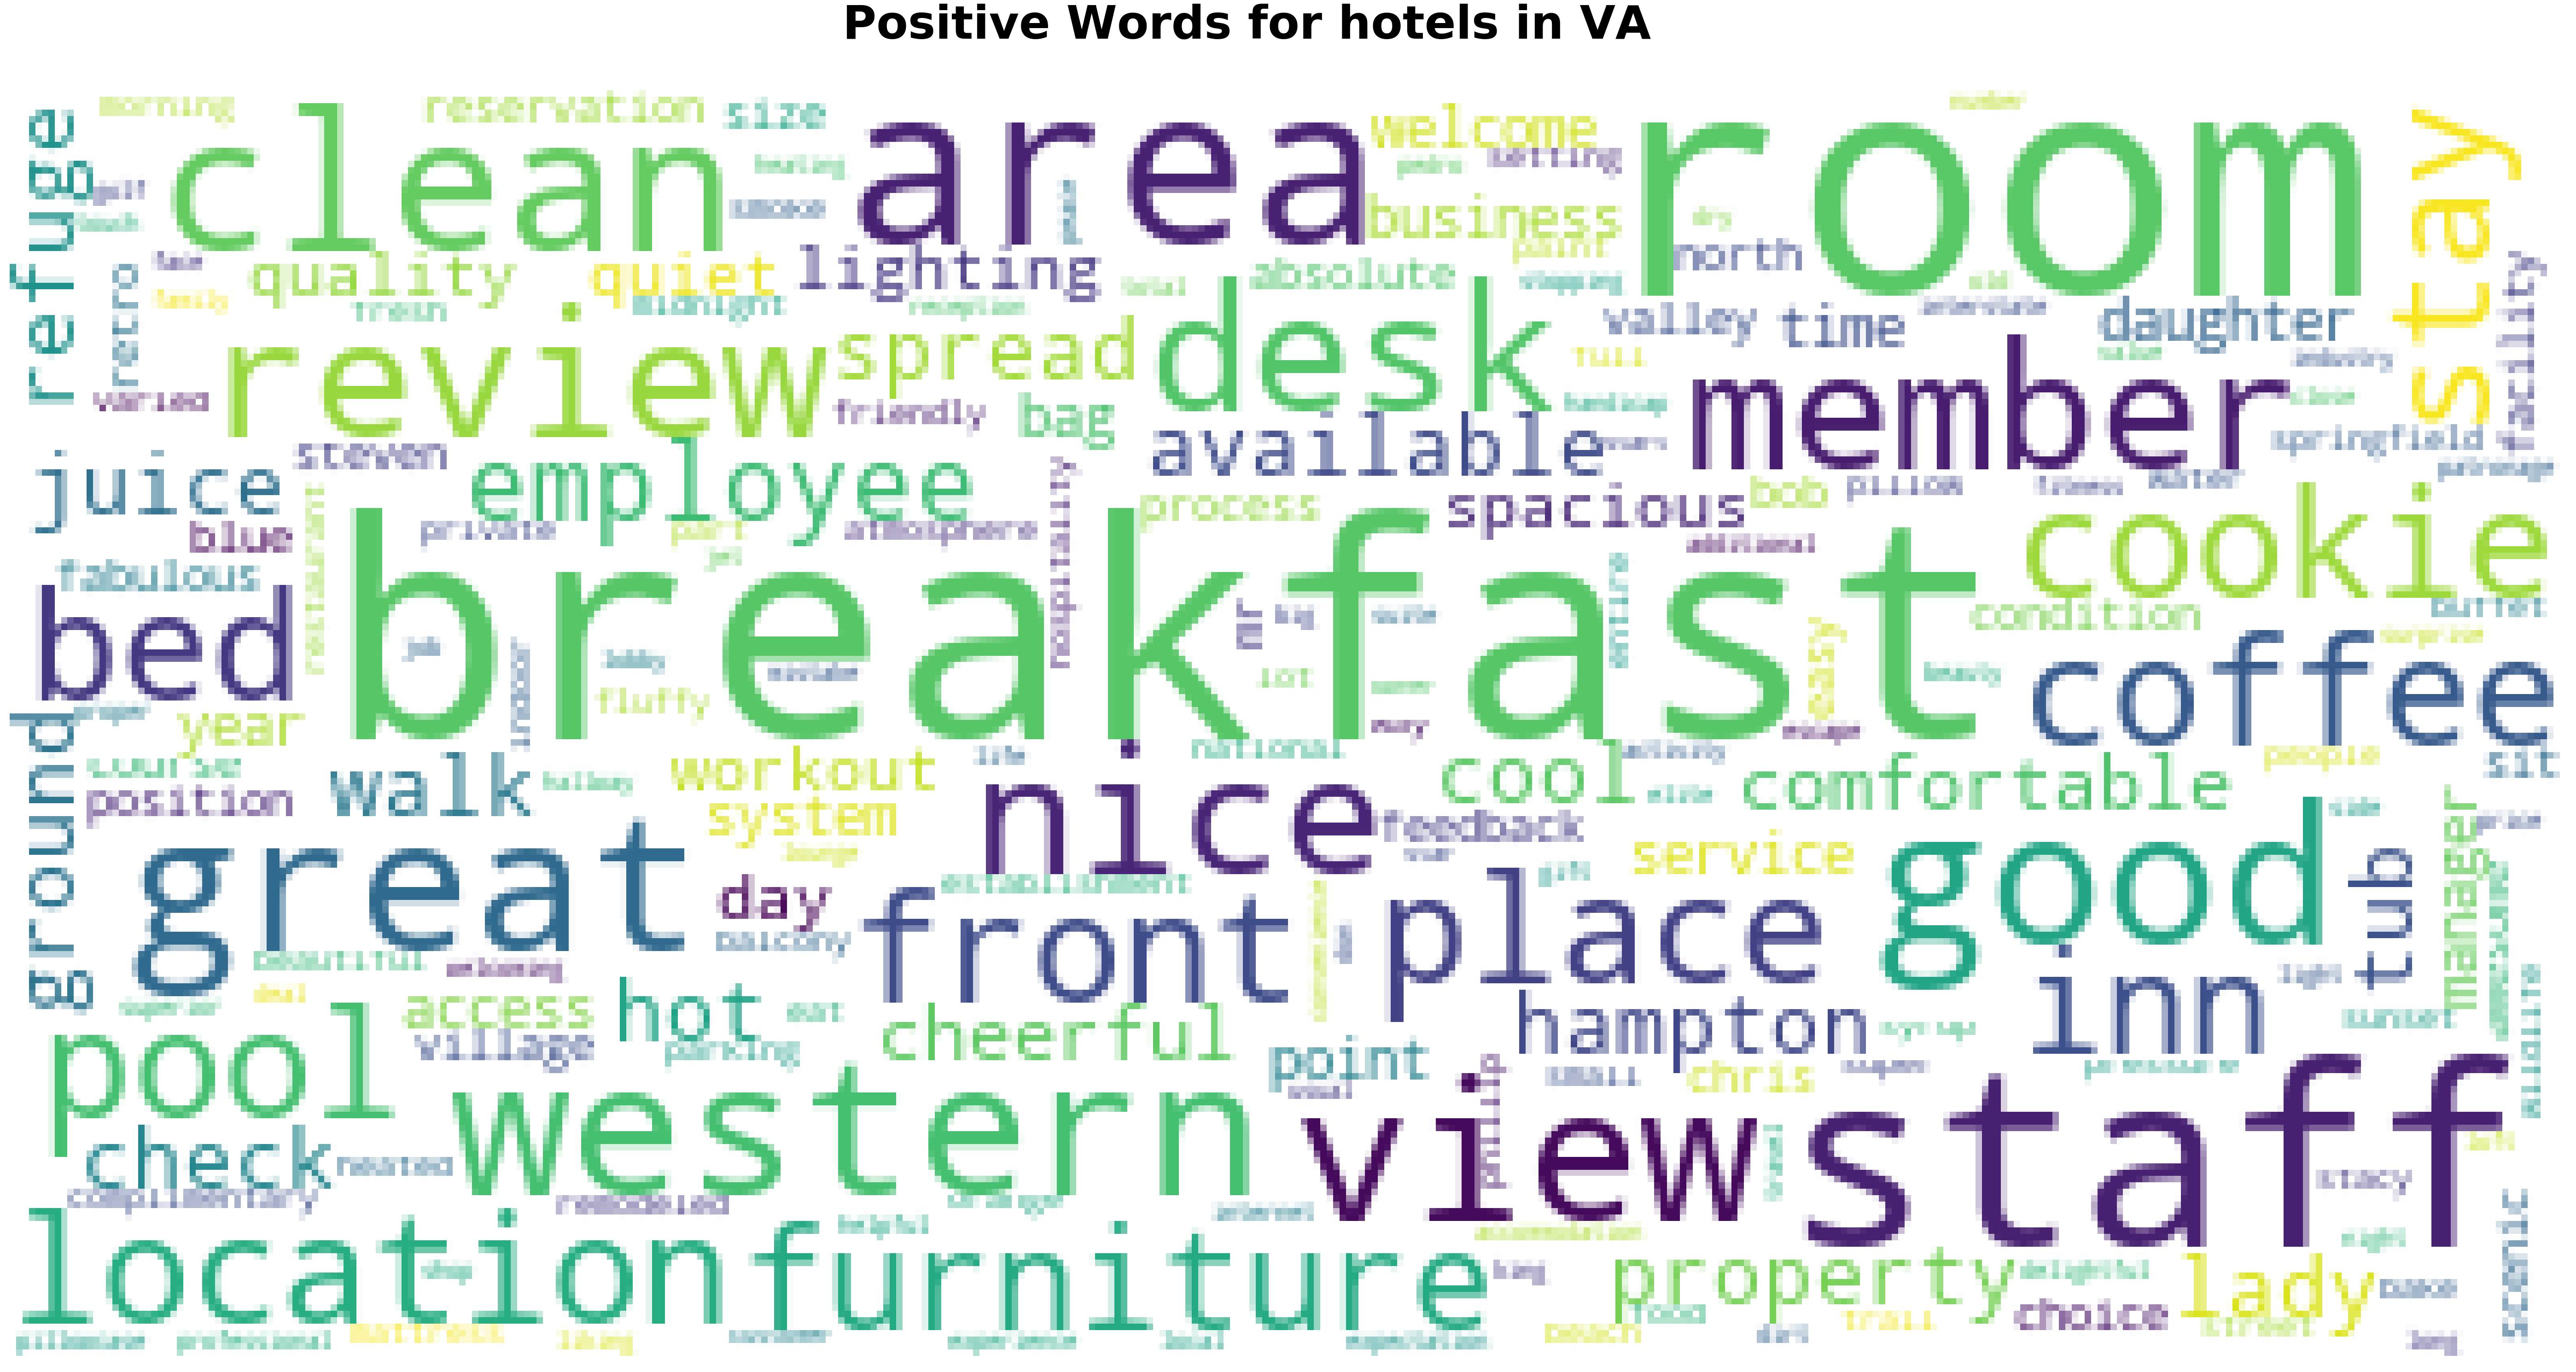

In [83]:
text_pos, text_neg = gen_text(VA_term_dict)
wc(text_pos,'white','Positive Words for hotels in VA' )

## Negative Words for VA Hotels

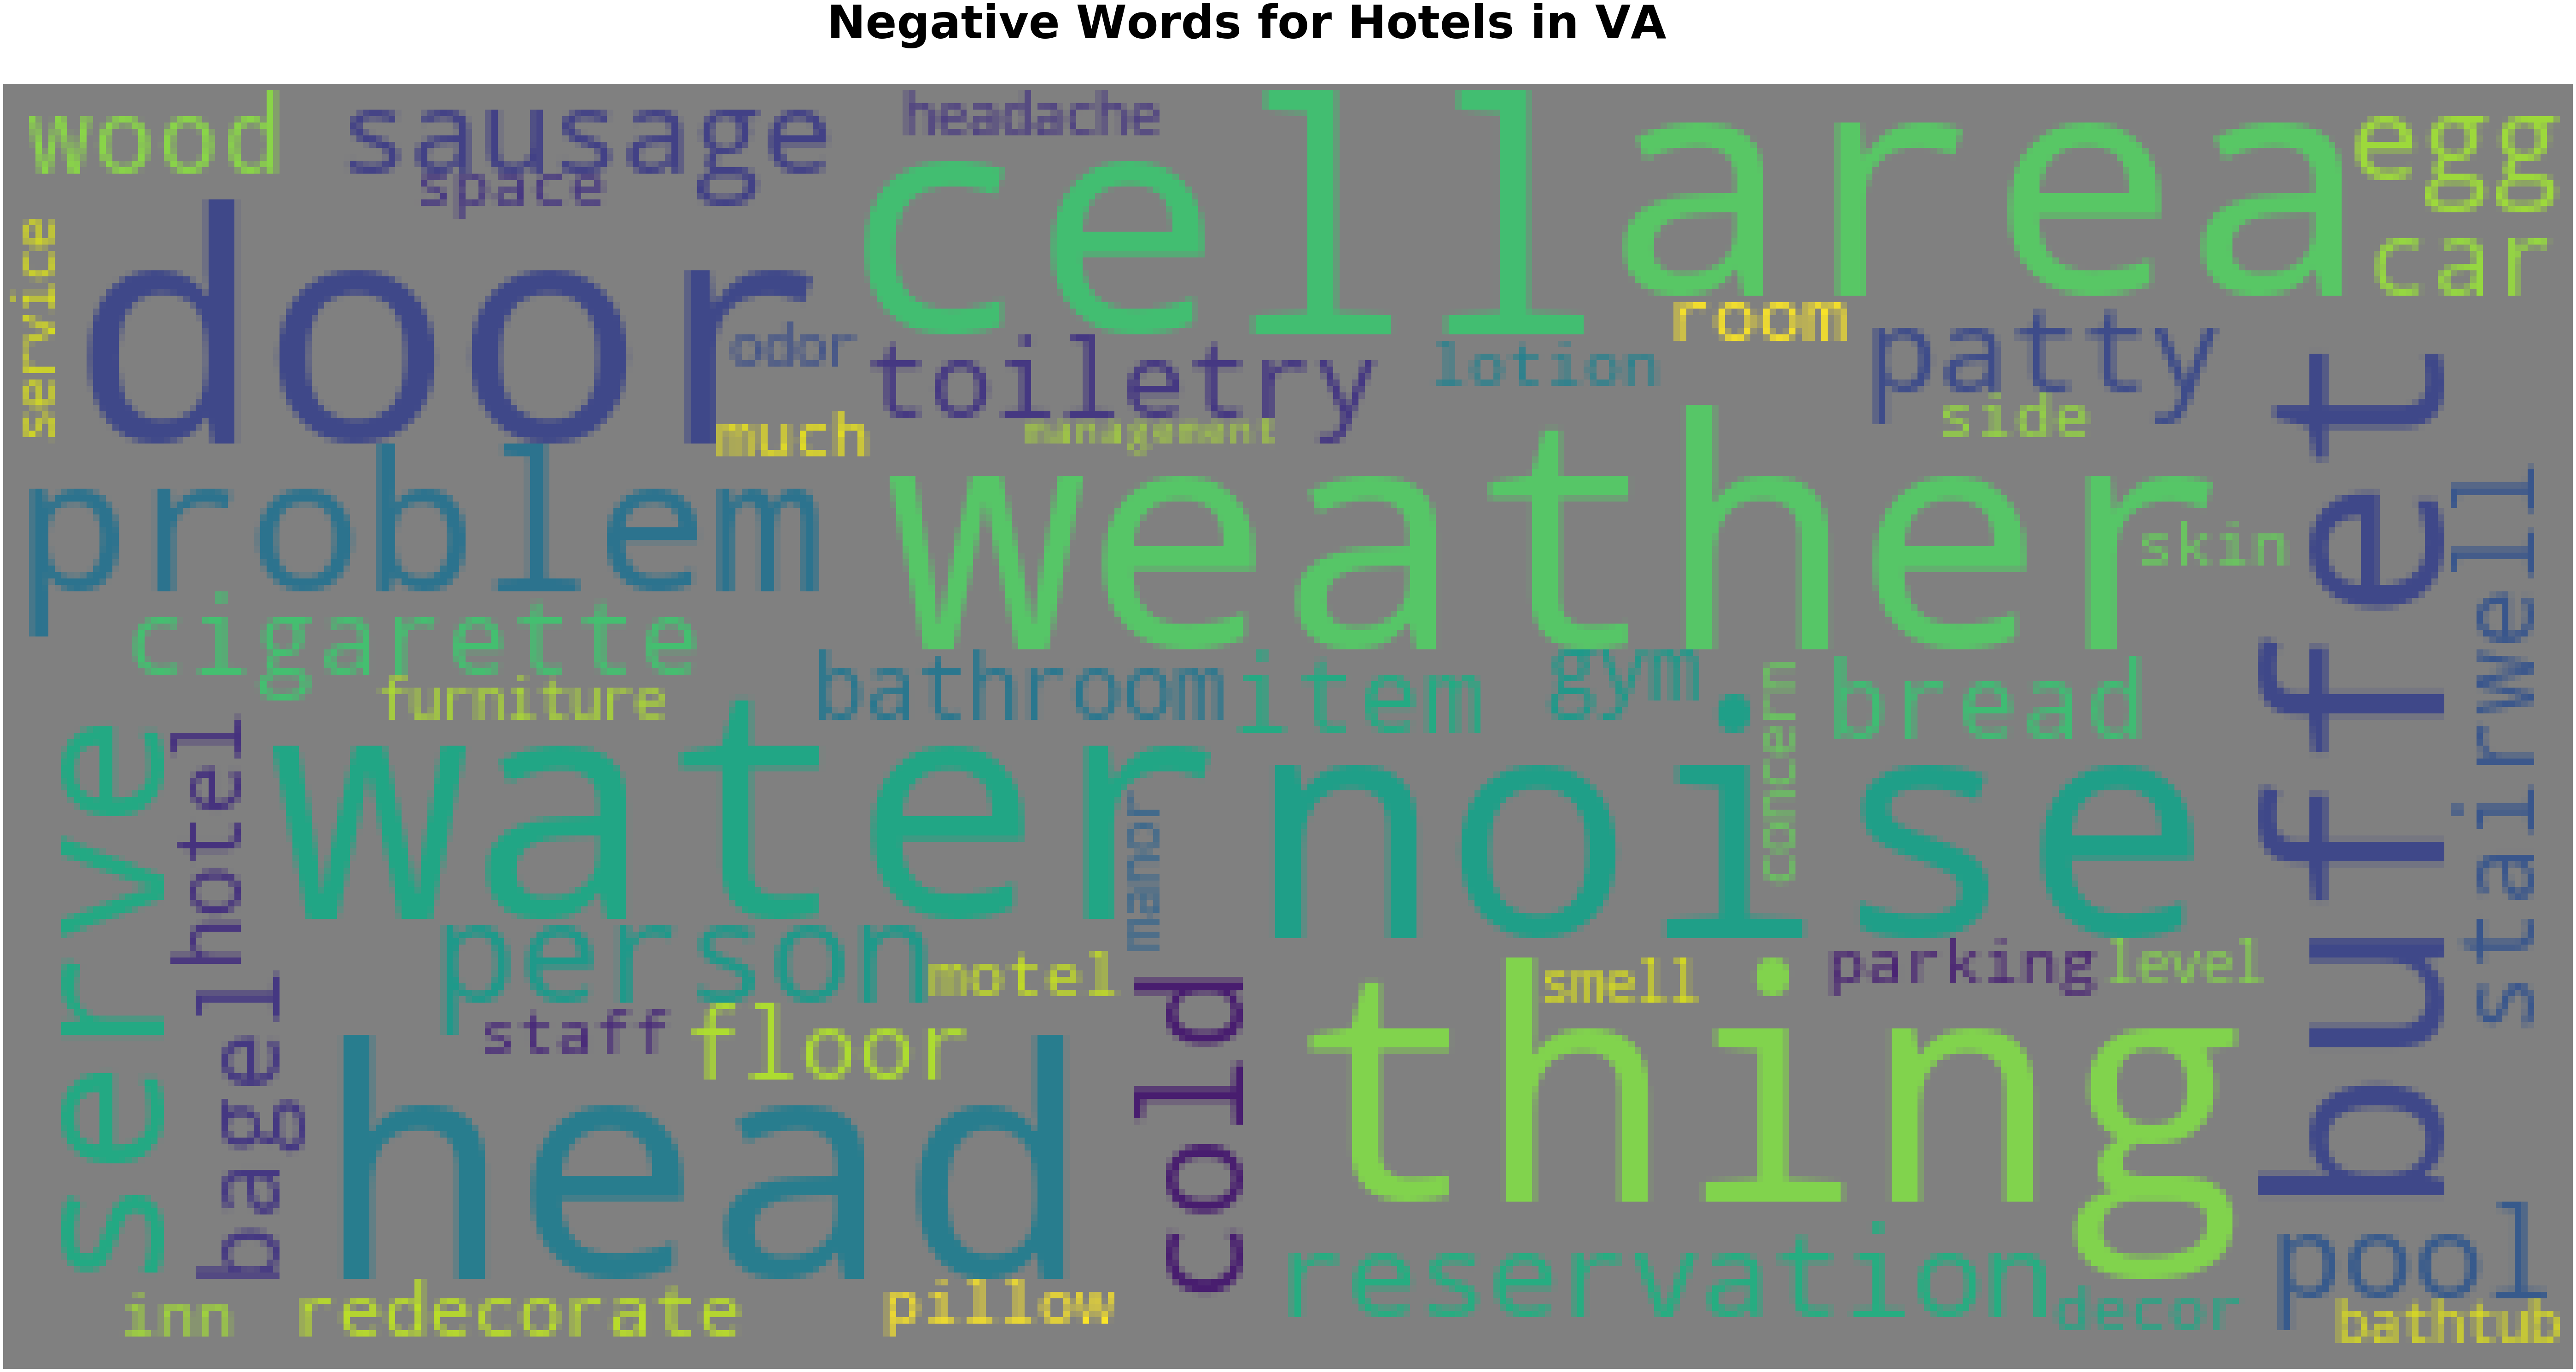

In [84]:
wc(text_neg,'grey','Negative Words for Hotels in VA' )